In [1]:
# Installation of Required Libraries
!pip install torch torchvision torchaudio transformers datasets scikit-learn matplotlib

In [2]:
#import os

#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
#os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"]="0.7"

In [3]:
# Fine-Tune the Model:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Split the data
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    disable_tqdm=False,
    report_to=[]
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="binary")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the model and tokenizer
model_path = "./fine-tuned-bert-large-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jigarpatel/.pyenv/versions/eleven/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.200300,0.152638,0.942800,0.942478,0.947816,0.937200
1,0.192400,0.149106,0.946360,0.945934,0.953507,0.938480
2,0.054800,0.203229,0.949560,0.949671,0.947591,0.951760


('./fine-tuned-bert-large-uncased/tokenizer_config.json',
 './fine-tuned-bert-large-uncased/special_tokens_map.json',
 './fine-tuned-bert-large-uncased/vocab.txt',
 './fine-tuned-bert-large-uncased/added_tokens.json')

In [4]:
# Load the Model for Inference:
# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set the device
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.to(device)

# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return torch.argmax(probs).item()

# Test inference
sample_text = "I absolutely loved this movie! The performances were stellar."
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")


/var/folders/51/ygbp8z0j7r57_z285c01c66w0000gn/T/ipykernel_1644/2659387290.py:7: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


Sentiment: Positive


In [5]:
# Check if MPS is available and set the device
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
print("Device: ", device)

Device:  mps


/var/folders/51/ygbp8z0j7r57_z285c01c66w0000gn/T/ipykernel_1644/15265501.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


In [15]:
# Test inference
sample_text = "This is ok but could have been lot better"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "dog is barking to someone who shows up at the door"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "you are fucking awesome"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "you are fucking terrible"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "redical policies to end the failure of community care"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "why was schizophrenic freed to kill my father"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "wicked nurse suspected of over 30 sabotage incidents"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

# Test inference
sample_text = "fake doctor gave two injections to patients"
print("Sentiment:", "Positive" if predict_sentiment(sample_text) == 1 else "Negative")

Sentiment: Negative
Sentiment: Negative
Sentiment: Positive
Sentiment: Negative
Sentiment: Positive
Sentiment: Negative
Sentiment: Negative
Sentiment: Negative


In [5]:
# upload all finetuned files to the huggingface hub
from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
import os

# Step 1: Define repository ID and local directory
repo_id = "jigarcpatel/fine-tuned-bert-large-uncased-IMDB-dataset"
local_dir = "./fine-tuned-bert-large-uncased"

# Step 2: List the files you want to upload
files_to_upload = [
    "config.json",
    "model.safetensors",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "vocab.txt"
]

# Step 3: Read the files and prepare them for upload
operations = []
for file_name in files_to_upload:
    file_path = os.path.join(local_dir, file_name)
    with open(file_path, "rb") as f:
        operations.append(
            CommitOperationAdd(path_in_repo=file_name, path_or_fileobj=f.read())
        )

# Step 4: Commit and push the files to the repository
api = HfApi()
api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message="Add fine-tuned model files",
    token=HfFolder.get_token()
)


CommitInfo(commit_url='https://huggingface.co/jigarcpatel/fine-tuned-bert-large-uncased-IMDB-dataset/commit/6162614ddba7a077363a9c2623ab93e474286fb6', commit_message='Add fine-tuned model files', commit_description='', oid='6162614ddba7a077363a9c2623ab93e474286fb6', pr_url=None, pr_revision=None, pr_num=None)

/var/folders/51/ygbp8z0j7r57_z285c01c66w0000gn/T/ipykernel_1644/620479246.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


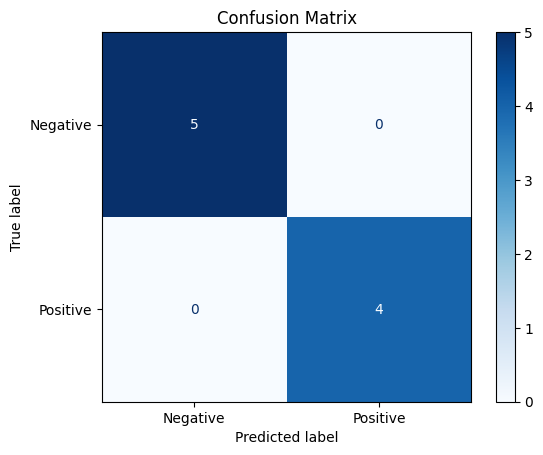

In [28]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load your fine-tuned model and tokenizer
model_path = "./fine-tuned-bert-large-uncased"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set the device
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.to(device)

# Assuming `test_dataset` is your dataset in a compatible format
# It should be a list of dictionaries with "text" and "label" keys

# Define a function to get predictions
def get_predictions(model, tokenizer, dataset):
    predictions, true_labels = [], []
    model.eval()  # Set model to evaluation mode
    for i in range(len(dataset)):
        inputs = tokenizer(dataset[i]["text"], return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predictions.append(torch.argmax(probs).item())
        true_labels.append(dataset[i]["label"])
    return predictions, true_labels

# Assuming `test_dataset` is a list of dictionaries with 'text' and 'label' keys
test_dataset = [
    {"text": "This movie was great!", "label": 1},
    {"text": "I did not like this movie.", "label": 0},
    {"text": "This movie is awesome.", "label": 1},
    {"text": "Food poisoning reaches epidemic level.", "label": 0},
    {"text": "iPhone 11 heating problem after 15.4.1 upgrade.", "label": 0},
    {"text": "Depressed mood during pet bereavement is common", "label": 0},
    {"text": "What to Eat After a Workout for Nutrition and Muscle Recovery", "label": 1},
    {"text": "my iPhone X began to heat up even for doing a little stuff in the really light apps much more faster than the iOS 13.7 hence please share with me if you've been dealing with the same issue.", "label": 0},
    {"text": "the battery does not drain faster and it seems ok", "label": 1},
    # Add more examples here
]

# Get predictions and true labels
predictions, true_labels = get_predictions(model, tokenizer, test_dataset)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


/var/folders/51/ygbp8z0j7r57_z285c01c66w0000gn/T/ipykernel_1644/2704425639.py:21: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


Accuracy: 0.8841743119266054
Precision: 0.8720173535791758
Recall: 0.9054054054054054
F1 Score: 0.8883977900552487


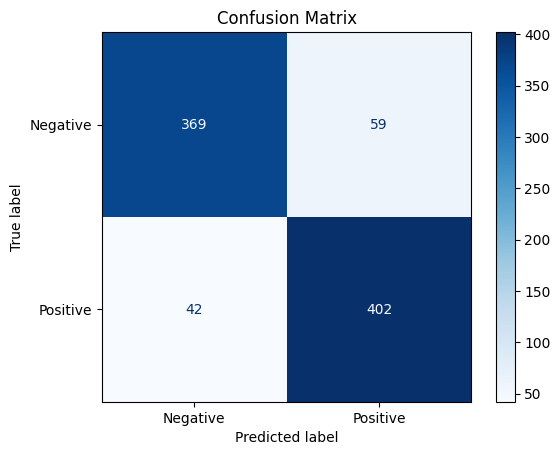

In [30]:
# benchmark with SST-2 dataset

# Install necessary libraries
# !pip install transformers datasets scikit-learn torch

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the tokenizer and model
model_path = "./fine-tuned-bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Set the device
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.to(device)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create DataLoader for evaluation
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(encoded_dataset['validation'], batch_size=8)

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            pred_labels = torch.argmax(probs, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, eval_dataloader)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.8841743119266054
Precision: 0.8720173535791758
Recall: 0.9054054054054054
F1 Score: 0.8883977900552487


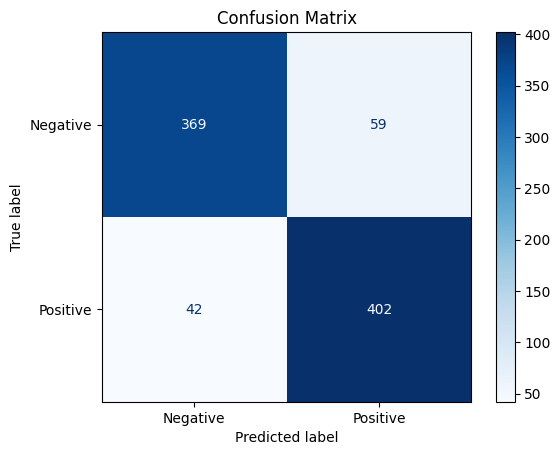


False Positives:
unflinchingly bleak and desperate 
pumpkin takes an admirable look at the hypocrisy of political correctness , but it does so with such an uneven tone that you never know when humor ends and tragedy begins . 
the iditarod lasts for days - this just felt like it did . 
holden caulfield did it better . 
the title not only describes its main characters , but the lazy people behind the camera as well . 
you wonder why enough was n't just a music video rather than a full-length movie . 
for all its impressive craftsmanship , and despite an overbearing series of third-act crescendos , lily chou-chou never really builds up a head of emotional steam . 
you wo n't like roger , but you will quickly recognize him . 
this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms . 
sam mendes has become valedictorian at the school for soft landings and easy ways out . 
it seems to me the film is abou

In [31]:
# benchmark with SST-2 dataset
# print all the false positive cases separately and all the false negative cases separately

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load the tokenizer and model
model_path = "./fine-tuned-bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Set the device
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.to(device)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label', 'sentence'])

# Create DataLoader for evaluation
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(encoded_dataset['validation'], batch_size=8)

# Function to get predictions and true labels along with their sentences
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels, sentences = [], [], []
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(device)
        batch_sentences = batch['sentence']
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            pred_labels = torch.argmax(probs, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            sentences.extend(batch_sentences)
    return predictions, true_labels, sentences

# Get predictions, true labels and sentences
predictions, true_labels, sentences = get_predictions(model, eval_dataloader)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print false positives and false negatives
false_positives = []
false_negatives = []

for sentence, true_label, pred_label in zip(sentences, true_labels, predictions):
    if true_label == 0 and pred_label == 1:
        false_positives.append(sentence)
    elif true_label == 1 and pred_label == 0:
        false_negatives.append(sentence)

print("\nFalse Positives:")
for sentence in false_positives:
    print(sentence)

print("\nFalse Negatives:")
for sentence in false_negatives:
    print(sentence)


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [22:26<00:00,  2.15s/it]

Accuracy: 0.9096
Precision: 0.8826835902085222
Recall: 0.9498536585365853
F1 Score: 0.9150375939849624


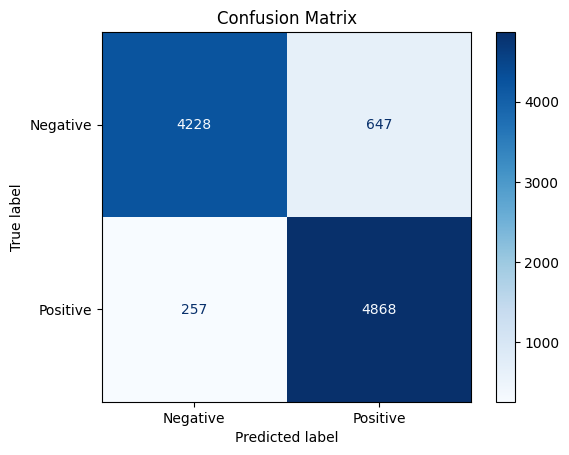


False Positives:
Index: 6, Predicted Label: 1, Actual Label: 0
Review: I love the style of this, but after a couple years, the DVD is giving me problems. It doesn't even work anymore and I use my broken PS2 Now. I wouldn't recommend this, I'm just going to upgrade to a recorder now. I wish it would work but I guess i'm giving up on JVC. I really did like this one... before it stopped working. The dvd player gave me problems probably after a year of having it.

Index: 9, Predicted Label: 1, Actual Label: 0
Review: Firstly,I enjoyed the format and tone of the book (how the author addressed the reader). However, I did not feel that she imparted any insider secrets that the book promised to reveal. If you are just starting to research law school, and do not know all the requirements of admission, then this book may be a tremendous help. If you have done your homework and are looking for an edge when it comes to admissions, I recommend some more topic-specific books. For example, books on 

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the Amazon Review dataset
dataset = load_dataset("amazon_polarity")

# Load the tokenizer and model
model_path = "./fine-tuned-bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples["content"], truncation=True, padding="max_length", max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create a subset of the first 100 examples
subset_dataset = Subset(encoded_dataset['test'], range(10000))

# Create DataLoader for evaluation
eval_dataloader = DataLoader(subset_dataset, batch_size=16)

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    num_batches = len(dataloader)
    for batch in tqdm(dataloader, total=num_batches, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)
            pred_labels = torch.argmax(probs, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, eval_dataloader)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Identify false positives and false negatives
false_positives = []
false_negatives = []

for i in range(len(true_labels)):
    if true_labels[i] != predictions[i]:
        if predictions[i] == 1:  # Predicted positive, actual negative (False Positive)
            false_positives.append((i, predictions[i], true_labels[i], dataset['test'][i]['content']))
        else:  # Predicted negative, actual positive (False Negative)
            false_negatives.append((i, predictions[i], true_labels[i], dataset['test'][i]['content']))

# Print false positives
print("\nFalse Positives:")
for fp in false_positives:
    print(f"Index: {fp[0]}, Predicted Label: {fp[1]}, Actual Label: {fp[2]}")
    print(f"Review: {fp[3]}\n")

# Print false negatives
print("\nFalse Negatives:")
for fn in false_negatives:
    print(f"Index: {fn[0]}, Predicted Label: {fn[1]}, Actual Label: {fn[2]}")
    print(f"Review: {fn[3]}\n")


In [7]:
# Load model from huggingface hub and run the inference 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Step 1: Define the model and tokenizer names
model_name = "jigarcpatel/fine-tuned-bert-large-uncased-IMDB-dataset"
tokenizer_name = "jigarcpatel/fine-tuned-bert-large-uncased-IMDB-dataset"

# Step 2: Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Step 3: Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Step 4: Define a function for inference
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions.item()

# Step 5: Example usage of the predict_sentiment function
if __name__ == "__main__":
    text = "This movie was really great! I enjoyed every bit of it."
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")

# Step 6: Example usage of the predict_sentiment function for negative case possily
if __name__ == "__main__":
    text = "Dog is barking anyone who shows up at the door."
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")


Text: This movie was really great! I enjoyed every bit of it.
Predicted Sentiment: Positive
Text: Dog is barking anyone who shows up at the door.
Predicted Sentiment: Negative
